# Model

In this notebook we train a number of classifiers to determine if a person is high income from the census data
We first pre-process the data
Then we fit several models and evaluate them

We try a number of known algorithms methods:
1. Logisitic Regression
2. Naive Bayes
3. Decision Tree
4. Random Forest
5. K-Nearest Neigbours
6. Gradient Boosting
7. Artificial Neural Network

The performance of all models is tested on variations of the training dataset. One with re-sampling of the minority class
income > 50K and one without any resampling. This is due to the significant class imbalance present in the dataset

It is worth noting that:
The models are all used with some default parameters and are trained on the entirety of the training data
No hyperparameter tuning on validation data (or cross-validation) was performed

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Loading in Data

In [2]:
# Read in the train/test census datasets
income_train_df = pd.read_csv('data/census_train_clean.csv', index_col=0)
income_test_df = pd.read_csv('data/census_test_clean.csv', index_col=0)

In [3]:
income_train_df.head()

,age,class of worker,education,marital stat,race,sex,full or part time employment stat,capital gains,capital losses,dividends from stocks,num persons worked for employer,citizenship,weeks worked in year,income
0,58,Self-employed-not incorporated,3,0,White,0,Armed Forces,0,0,0,1,Native- Born in the United States,52,0
1,48,Private,3,1,Amer Indian Aleut or Eskimo,1,Full Time,0,0,0,1,Native- Born in the United States,52,0
2,42,Private,5,1,White,0,Armed Forces,5178,0,0,6,Native- Born in the United States,52,0
3,28,Private,3,0,White,1,Unemployed,0,0,0,4,Native- Born in the United States,30,0
4,47,Local government,3,1,White,1,Full Time,0,0,0,5,Native- Born in the United States,52,0


In [4]:
print(f'Train dataset has {len(income_train_df):,} datapoints with proportion of high income earners: {income_train_df.income.mean()}')

Train dataset has 96,535 datapoints with proportion of high income earners: 0.11887916299787642


In [5]:
print(f'Test dataset has {len(income_test_df):,} datapoints with proportion of high income earners: {income_test_df.income.mean()}')

Test dataset has 48,338 datapoints with proportion of high income earners: 0.11876784310480368


## Feature Engineering and Data Pre-processing

In [6]:
# Get dummy variables for categorical data
categorical_cols = income_train_df.columns[income_train_df.dtypes==object].tolist()

income_train_df1 = pd.get_dummies(income_train_df, columns=categorical_cols)
income_test_df1 = pd.get_dummies(income_test_df, columns=categorical_cols)

In [7]:
# Scale numerical data using minmax scaler to keep all input and output dimension in same scale
from sklearn.preprocessing import MinMaxScaler

numerical_columns = [col for col in income_train_df if col not in categorical_cols + ['income']]

# Get min max-scaler
mms = MinMaxScaler()
# Fit scaler to training data and transform it
min_max_scaled_columns_train = mms.fit_transform(income_train_df1[numerical_columns])
# Using fit to training data, transform the test data
min_max_scaled_columns_test = mms.transform(income_test_df1[numerical_columns])

for i, col in enumerate(numerical_columns):
    income_train_df1[col] = min_max_scaled_columns_train[:,i]
    income_test_df1[col] = min_max_scaled_columns_test[:, i]

In [8]:
income_train_df1.head()

,age,education,marital stat,sex,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year,income,...,full or part time employment stat_Armed Forces,full or part time employment stat_Full Time,full or part time employment stat_Not in labor force,full or part time employment stat_Part Time,full or part time employment stat_Unemployed,citizenship_ Foreign born- Not a citizen of U S,citizenship_ Foreign born- U S citizen by naturalization,citizenship_ Native- Born abroad of American Parent(s),citizenship_ Native- Born in Puerto Rico or U S Outlying,citizenship_ Native- Born in the United States
0,0.555556,0.428571,0.0,0.0,0.000000,0.0,0.0,0.166667,1.000000,0,...,1,0,0,0,0,0,0,0,0,1
1,0.416667,0.428571,1.0,1.0,0.000000,0.0,0.0,0.166667,1.000000,0,...,0,1,0,0,0,0,0,0,0,1
2,0.333333,0.714286,1.0,0.0,0.051781,0.0,0.0,1.000000,1.000000,0,...,1,0,0,0,0,0,0,0,0,1
3,0.138889,0.428571,0.0,1.0,0.000000,0.0,0.0,0.666667,0.576923,0,...,0,0,0,0,1,0,0,0,0,1
4,0.402778,0.428571,1.0,1.0,0.000000,0.0,0.0,0.833333,1.000000,0,...,0,1,0,0,0,0,0,0,0,1


## Utility Functions

In [9]:
from imblearn.over_sampling import SMOTE

def get_train_test_data(train_data: pd.DataFrame, test_data: pd.DataFrame, target: str, imbalance_adjustment: bool):
    """
    This function get the training and testing data in the required format. Does minority resampling using the SMOTE
    method based on user preference
    """
    
    X_train = train_data.drop(target, axis=1)
    Y_train = train_data[target]
    
    X_test = test_data.drop(target, axis=1)
    Y_test = test_data[target]
    
    if imbalance_adjustment:
        X_train, Y_train = SMOTE(sampling_strategy='minority').fit_resample(X_train, Y_train)
        
    return X_train, Y_train, X_test, Y_test

In [10]:
# Utility functions to train and evaluate (make predictions) the model
def train_model(model, X_train, Y_train):
    model.fit(X_train, Y_train)
    return model

def evaluate_model(model, X_test, Y_test=None):
    if Y_test is None:
        predictions = model.predict(X_test)
    else:
        predictions = model.predict(X_test, Y_test)
    return predictions

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# A utility function to get metrics based on model predictions
  
def get_metrics(labels, predictions):
    accuracy = accuracy_score(labels, predictions)
    balanced_accuracy = balanced_accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, labels=[0, 1], average=None)
    precision = precision_score(labels, predictions, labels=[0, 1], average=None)
    f1 = f1_score(labels, predictions)
    roc = roc_auc_score(labels, predictions)
    
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Balanced Accuracy: {balanced_accuracy:.2f}')
    print(f'Recall [0, 1]: {recall}')
    print(f'Precision [0, 1]: {precision}')
    print(f'f1: {f1:.2f}')
    print(f'ROC AUC: {roc:.2f}')
    
    return accuracy, balanced_accuracy, recall, precision, f1, roc
    
# A utility function to plot the confusion matrix
def plot_normalised_confusion_matrix(labels, predictions, title): 
    cm = confusion_matrix(Y_test, predictions)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(3,3))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show(block=False)
    

In [12]:
# Get the train and test data
X_train, Y_train, X_test, Y_test = get_train_test_data(income_train_df1, income_test_df1, 'income', False)
X_train_adj, Y_train_adj, _, _ = get_train_test_data(income_train_df1, income_test_df1, 'income', True)

## Logisitic Regression

In [13]:
from sklearn.linear_model import LogisticRegression


LR_model1 = train_model(LogisticRegression(solver = 'newton-cholesky'), X_train, Y_train)
LR_model2 = train_model(LogisticRegression(solver = 'newton-cholesky'), X_train_adj, Y_train_adj)

LR_model1_pred = evaluate_model(LR_model1, X_test)
LR_model2_pred = evaluate_model(LR_model2, X_test)

In [14]:
LR1_acc, LR1_bacc, LR1_rec, LR1_prec, LR1_f1, LR1_roc = get_metrics(Y_test, LR_model1_pred)

Accuracy: 0.91
Balanced Accuracy: 0.66
Recall [0, 1]: [0.98227575 0.33931371]
Precision [0, 1]: [0.91688397 0.72068073]
f1: 0.46
ROC AUC: 0.66


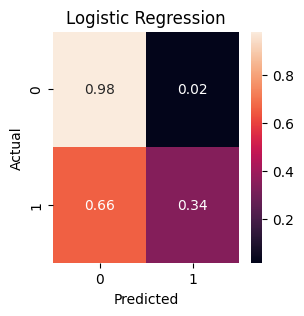

In [15]:
plot_normalised_confusion_matrix(Y_test, LR_model1_pred, 'Logistic Regression')

In [16]:
LR2_acc, LR2_bacc, LR2_rec, LR2_prec, LR2_f1, LR2_roc = get_metrics(Y_test, LR_model2_pred)

Accuracy: 0.81
Balanced Accuracy: 0.80
Recall [0, 1]: [0.81179426 0.79237067]
Precision [0, 1]: [0.96667785 0.36200859]
f1: 0.50
ROC AUC: 0.80


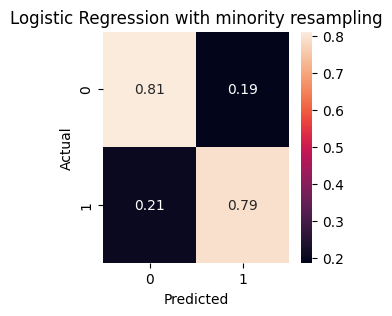

In [17]:
plot_normalised_confusion_matrix(Y_test, LR_model2_pred, 'Logistic Regression with minority resampling')

## Naive Bayes

In [18]:
from sklearn.naive_bayes import GaussianNB

NB_model1 = train_model(GaussianNB(), X_train, Y_train)
NB_model2 = train_model(GaussianNB(), X_train_adj, Y_train_adj)

NB_model1_pred = evaluate_model(NB_model1, X_test)
NB_model2_pred = evaluate_model(NB_model2, X_test)

In [19]:
NB1_acc, NB1_bacc, NB1_rec, NB1_prec, NB1_f1, NB1_roc = get_metrics(Y_test, NB_model1_pred)

Accuracy: 0.81
Balanced Accuracy: 0.77
Recall [0, 1]: [0.81707632 0.72757359]
Precision [0, 1]: [0.95699634 0.34898488]
f1: 0.47
ROC AUC: 0.77


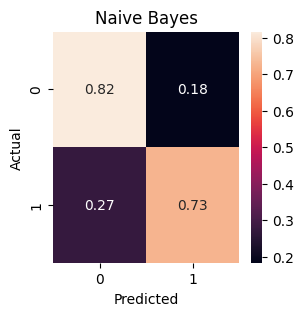

In [20]:
plot_normalised_confusion_matrix(Y_test, NB_model1_pred, 'Naive Bayes')

In [21]:
NB2_acc, NB2_bacc, NB2_rec, NB2_prec, NB2_f1, NB2_roc = get_metrics(Y_test, NB_model2_pred)

Accuracy: 0.44
Balanced Accuracy: 0.65
Recall [0, 1]: [0.3718337  0.92022296]
Precision [0, 1]: [0.97189667 0.16488249]
f1: 0.28
ROC AUC: 0.65


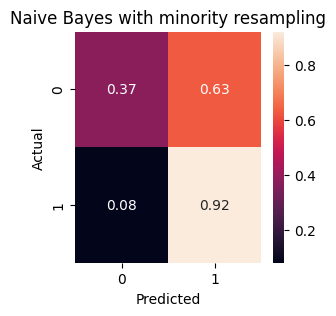

In [22]:
plot_normalised_confusion_matrix(Y_test, NB_model2_pred, 'Naive Bayes with minority resampling')

## Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier

DT_model1 = train_model(DecisionTreeClassifier(criterion='entropy',min_samples_split=8,max_depth=10), X_train, Y_train)
DT_model2 = train_model(DecisionTreeClassifier(criterion='entropy',min_samples_split=8,max_depth=10), X_train_adj, Y_train_adj)

DT_model1_pred = evaluate_model(DT_model1, X_test)
DT_model2_pred = evaluate_model(DT_model2, X_test)

In [24]:
DT1_acc, DT1_bacc, DT1_rec, DT1_prec, DT1_f1, DT1_roc = get_metrics(Y_test, DT_model1_pred)

Accuracy: 0.91
Balanced Accuracy: 0.69
Recall [0, 1]: [0.97689978 0.40968472]
Precision [0, 1]: [0.92469224 0.70503597]
f1: 0.52
ROC AUC: 0.69


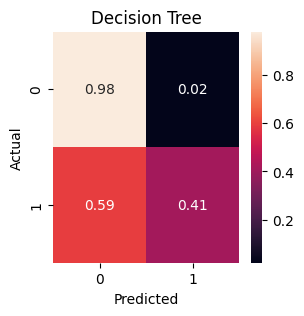

In [25]:
plot_normalised_confusion_matrix(Y_test, DT_model1_pred, 'Decision Tree')

In [26]:
DT2_acc, DT2_bacc, DT2_rec, DT2_prec, DT2_f1, DT2_roc = get_metrics(Y_test, DT_model2_pred)

Accuracy: 0.86
Balanced Accuracy: 0.78
Recall [0, 1]: [0.88388854 0.67810486]
Precision [0, 1]: [0.95321401 0.44043444]
f1: 0.53
ROC AUC: 0.78


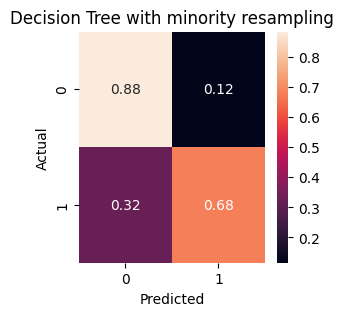

In [27]:
plot_normalised_confusion_matrix(Y_test, DT_model2_pred, 'Decision Tree with minority resampling')

## Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

RF_model1 = train_model(RandomForestClassifier(n_estimators=100), X_train, Y_train)
RF_model2 = train_model(RandomForestClassifier(n_estimators=100), X_train_adj, Y_train_adj)

RF_model1_pred = evaluate_model(RF_model1, X_test)
RF_model2_pred = evaluate_model(RF_model2, X_test)

In [29]:
RF1_acc, RF1_bacc, RF1_rec, RF1_prec, RF1_f1, RF1_roc = get_metrics(Y_test, RF_model1_pred)

Accuracy: 0.90
Balanced Accuracy: 0.70
Recall [0, 1]: [0.96537315 0.44295419]
Precision [0, 1]: [0.92784296 0.63290194]
f1: 0.52
ROC AUC: 0.70


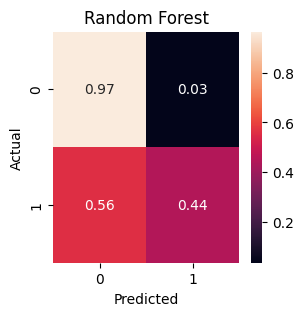

In [30]:
plot_normalised_confusion_matrix(Y_test, RF_model1_pred, 'Random Forest')

In [31]:
RF2_acc, RF2_bacc, RF2_rec, RF2_prec, RF2_f1, RF2_roc = get_metrics(Y_test, RF_model2_pred)

Accuracy: 0.87
Balanced Accuracy: 0.75
Recall [0, 1]: [0.90797474 0.59188295]
Precision [0, 1]: [0.94288152 0.46433452]
f1: 0.52
ROC AUC: 0.75


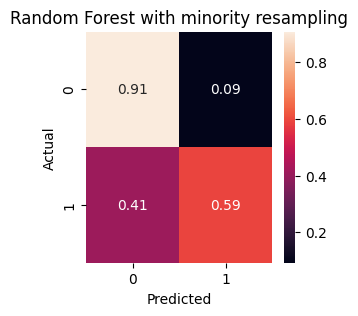

In [32]:
plot_normalised_confusion_matrix(Y_test, RF_model2_pred, 'Random Forest with minority resampling')

## K Nearest Neighbour

In [33]:
from sklearn.neighbors import KNeighborsClassifier

KNN_model1 = train_model(KNeighborsClassifier(), X_train, Y_train)
KNN_model2 = train_model(KNeighborsClassifier(), X_train_adj, Y_train_adj)

KNN_model1_pred = evaluate_model(KNN_model1, X_test)
KNN_model2_pred = evaluate_model(KNN_model2, X_test)

In [34]:
KNN1_acc, KNN1_bacc, KNN1_rec, KNN1_prec, KNN1_f1, KNN1_roc = get_metrics(Y_test, KNN_model1_pred)

Accuracy: 0.90
Balanced Accuracy: 0.66
Recall [0, 1]: [0.97140644 0.34088138]
Precision [0, 1]: [0.9162146  0.61637795]
f1: 0.44
ROC AUC: 0.66


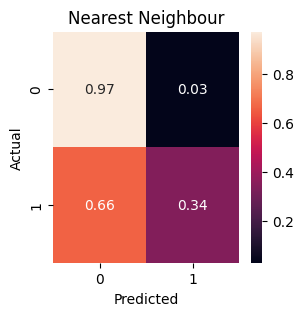

In [35]:
plot_normalised_confusion_matrix(Y_test, KNN_model1_pred, 'Nearest Neighbour')

In [36]:
KNN2_acc, KNN2_bacc, KNN2_rec, KNN2_prec, KNN2_f1, KNN2_roc = get_metrics(Y_test, KNN_model2_pred)

Accuracy: 0.83
Balanced Accuracy: 0.74
Recall [0, 1]: [0.86027185 0.61330779]
Precision [0, 1]: [0.9428792  0.37168796]
f1: 0.46
ROC AUC: 0.74


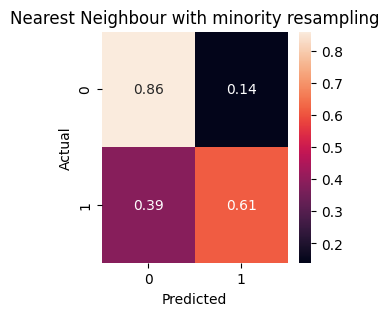

In [37]:
plot_normalised_confusion_matrix(Y_test, KNN_model2_pred, 'Nearest Neighbour with minority resampling')

## Gradient Boosting

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

GB_model1 = train_model(GradientBoostingClassifier(n_estimators=100), X_train, Y_train)
GB_model2 = train_model(GradientBoostingClassifier(n_estimators=100), X_train_adj, Y_train_adj)

GB_model1_pred = evaluate_model(GB_model1, X_test)
GB_model2_pred = evaluate_model(GB_model2, X_test)

In [39]:
GB1_acc, GB1_bacc, GB1_rec, GB1_prec, GB1_f1, GB1_roc = get_metrics(Y_test, GB_model1_pred)

Accuracy: 0.91
Balanced Accuracy: 0.69
Recall [0, 1]: [0.98100805 0.40306567]
Precision [0, 1]: [0.92420657 0.74095421]
f1: 0.52
ROC AUC: 0.69


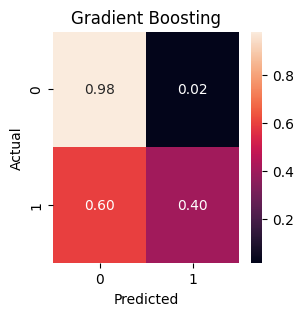

In [40]:
plot_normalised_confusion_matrix(Y_test, GB_model1_pred, 'Gradient Boosting')

In [41]:
GB2_acc, GB2_bacc, GB2_rec, GB2_prec, GB2_f1, GB2_roc = get_metrics(Y_test, GB_model2_pred)

Accuracy: 0.85
Balanced Accuracy: 0.81
Recall [0, 1]: [0.86196211 0.74917262]
Precision [0, 1]: [0.96226118 0.42245359]
f1: 0.54
ROC AUC: 0.81


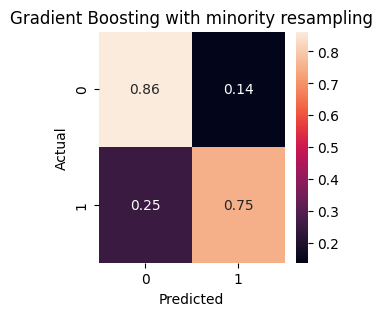

In [42]:
plot_normalised_confusion_matrix(Y_test, GB_model2_pred, 'Gradient Boosting with minority resampling')

## Neural Network

In [43]:
import torch
from torch.utils.data import Dataset, DataLoader

# This class is used to convert the dataset to a torch datset that can be handled by DataLoader and the model 
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values,dtype=torch.float32)
        self.y = torch.tensor(y.values,dtype=torch.float32)
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [44]:
from torch import nn

# We define the neural architecure used in our classifier. Here is a simple 3 layer network
class Network(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Network, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_3 = nn.Linear(hidden_dim, 1)
       
    def forward(self, x):
        x = nn.functional.relu(self.layer_1(x))
        x = nn.functional.relu(self.layer_2(x))
        x = torch.sigmoid(self.layer_3(x))

        return x

In [45]:
import itertools

# We define the classifer model here. We define a fit method to train the model and a predict method to get predictions 
# the trained model
# The methods inputs and outputs are compatible with the helper functions defined earlier
class NeuralNetworkModel:
    def __init__(self, input_dim, hidden_dim, network, batch_size=64, lr=0.1, epochs=10):
        self.net = network(input_dim, hidden_dim)
        self.batch_size = batch_size
        
        self.loss_fn = nn.BCELoss()
        self.optimizer = torch.optim.SGD(self.net.parameters(), lr=lr)
        self.epochs = epochs
        
    def fit(self, X_train, Y_train):
        train_data = Data(X_train, Y_train)
        train_dataloader = DataLoader(dataset=train_data, batch_size=self.batch_size, shuffle=True)
        
        for epoch in range(self.epochs):
            for X, y in train_dataloader:
                # zero the parameter gradients
                self.optimizer.zero_grad()
       
                # forward + backward + optimize
                pred = self.net(X)
                loss = self.loss_fn(pred, y.unsqueeze(-1))
                loss.backward()
                self.optimizer.step()
                
    def predict(self, X_test, Y_test):
        test_data = Data(X_test, Y_test)
        test_dataloader = DataLoader(dataset=test_data, batch_size=len(Y_test), shuffle=False)
        with torch.no_grad():
            for X, y in test_dataloader:
                outputs = self.net(X)
                predicted = np.where(outputs < 0.5, 0, 1)
                predicted = list(itertools.chain(*predicted))
                
        return predicted
           

In [46]:
# We define the NN classifier parameters
input_dim = X_train.shape[1]
hidden_dim = 64
batch_size = 64
lr = 0.1
epochs = 10

np.random.seed(0)
torch.manual_seed(0)

NN_model1 = train_model(NeuralNetworkModel(input_dim, hidden_dim, Network, batch_size, lr, epochs), X_train, Y_train)
NN_model2 = train_model(NeuralNetworkModel(input_dim, hidden_dim, Network, batch_size, lr, epochs), X_train_adj, Y_train_adj)

NN_model1_pred = evaluate_model(NN_model1, X_test, Y_test)
NN_model2_pred = evaluate_model(NN_model2, X_test, Y_test)

In [47]:
NN1_acc, NN1_bacc, NN1_rec, NN1_prec, NN1_f1, NN1_roc = get_metrics(Y_test, NN_model1_pred)

Accuracy: 0.90
Balanced Accuracy: 0.62
Recall [0, 1]: [0.99063314 0.25465947]
Precision [0, 1]: [0.90793296 0.78559914]
f1: 0.38
ROC AUC: 0.62


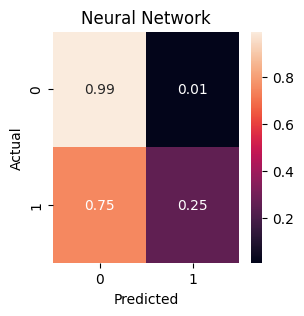

In [48]:
plot_normalised_confusion_matrix(Y_test, NN_model1_pred, 'Neural Network')

In [49]:
NN2_acc, NN2_bacc, NN2_rec, NN2_prec, NN2_f1, NN2_roc = get_metrics(Y_test, NN_model2_pred)

Accuracy: 0.86
Balanced Accuracy: 0.79
Recall [0, 1]: [0.8807193  0.69412994]
Precision [0, 1]: [0.95528621 0.43955438]
f1: 0.54
ROC AUC: 0.79


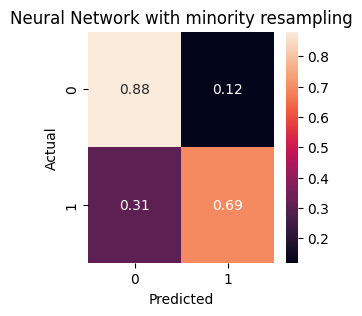

In [50]:
plot_normalised_confusion_matrix(Y_test, NN_model2_pred, 'Neural Network with minority resampling')

## Summary of Results

In [51]:
# Helper function for printing out model metrics
def print_summary_metrics(model_name, labels, predictions):
    accuracy = accuracy_score(labels, predictions)
    balanced_accuracy = balanced_accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, labels=[0, 1], average=None)
    precision = precision_score(labels, predictions, labels=[0, 1], average=None)
    f1 = f1_score(labels, predictions)
    roc = roc_auc_score(labels, predictions)
    
    print (f"{model_name:<20} {accuracy:<15.2f} {balanced_accuracy:<15.2f} {f1:<15.2f} {roc:<15.2f} {recall[0]:<5.2f},{recall[1]:<8.2f}  {precision[0]:<5.2f},{precision[1]:<8.2f}")
    

In [52]:
# The model names and their corresponding predicitions
models = ["Logistic Regression", "Naive Bayes", "Decision Tree", "Random Forest", "KNN", "Gradient Boosting", "Neural Network"]
preds = [LR_model1_pred, NB_model1_pred, DT_model1_pred, RF_model1_pred, KNN_model1_pred, GB_model1_pred, NN_model1_pred]
preds_adj = [LR_model2_pred, NB_model2_pred, DT_model2_pred, RF_model2_pred, KNN_model2_pred, GB_model2_pred, NN_model2_pred]


In [53]:
print(f"{'Model':20} {'Accuracy':15} {'Balance Acc':15} {'f1':15} {'AUC':15} {'Recall':15} {'Precision':15}")
for model, pred in zip(models, preds):
    print_summary_metrics(model, Y_test, pred)

Model                Accuracy        Balance Acc     f1              AUC             Recall          Precision      
Logistic Regression  0.91            0.66            0.46            0.66            0.98 ,0.34      0.92 ,0.72    
Naive Bayes          0.81            0.77            0.47            0.77            0.82 ,0.73      0.96 ,0.35    
Decision Tree        0.91            0.69            0.52            0.69            0.98 ,0.41      0.92 ,0.71    
Random Forest        0.90            0.70            0.52            0.70            0.97 ,0.44      0.93 ,0.63    
KNN                  0.90            0.66            0.44            0.66            0.97 ,0.34      0.92 ,0.62    
Gradient Boosting    0.91            0.69            0.52            0.69            0.98 ,0.40      0.92 ,0.74    
Neural Network       0.90            0.62            0.38            0.62            0.99 ,0.25      0.91 ,0.79    


In [54]:
print(f"{'Model':20} {'Accuracy':15} {'Balance Acc':15} {'f1':15} {'AUC':15} {'Recall':15} {'Precision':15}")
for model, pred in zip(models, preds_adj):
    print_summary_metrics(model, Y_test, pred)

Model                Accuracy        Balance Acc     f1              AUC             Recall          Precision      
Logistic Regression  0.81            0.80            0.50            0.80            0.81 ,0.79      0.97 ,0.36    
Naive Bayes          0.44            0.65            0.28            0.65            0.37 ,0.92      0.97 ,0.16    
Decision Tree        0.86            0.78            0.53            0.78            0.88 ,0.68      0.95 ,0.44    
Random Forest        0.87            0.75            0.52            0.75            0.91 ,0.59      0.94 ,0.46    
KNN                  0.83            0.74            0.46            0.74            0.86 ,0.61      0.94 ,0.37    
Gradient Boosting    0.85            0.81            0.54            0.81            0.86 ,0.75      0.96 ,0.42    
Neural Network       0.86            0.79            0.54            0.79            0.88 ,0.69      0.96 ,0.44    


In [55]:
models = ["Logistic Regression", "KNN", "Decision Tree", "Random Forest", "Gradient Boosting", "Neural Network"]

acc1 = [LR1_acc, KNN1_acc, DT1_acc, RF1_acc, GB1_acc, NN1_acc]
acc2 = [LR2_acc, KNN2_acc, DT2_acc, RF2_acc, GB2_acc, NN2_acc]

bacc1 = [LR1_bacc, KNN1_bacc, DT1_bacc, RF1_bacc, GB1_bacc, NN1_bacc]
bacc2 = [LR2_bacc, KNN2_bacc, DT2_bacc, RF2_bacc, GB2_bacc, NN2_bacc]

# Recall of the minority class
rec1 = [LR1_rec[1], KNN1_rec[1], DT1_rec[1], RF1_rec[1], GB1_rec[1], NN1_rec[1]]
rec2 = [LR2_rec[1], KNN2_rec[1], DT2_rec[1], RF2_rec[1], GB2_rec[1], NN2_rec[1]]

prec1 = [LR1_prec, KNN1_prec, DT1_prec, RF1_prec, GB1_prec, NN1_prec]
prec2 = [LR2_prec, KNN2_prec, DT2_prec, RF2_prec, GB2_prec, NN2_prec]

f11 = [LR1_f1, KNN1_f1, DT1_f1, RF1_f1, GB1_f1, NN1_f1]
f12 = [LR2_f1, KNN2_f1, DT2_f1, RF2_f1, GB2_f1, NN2_f1]

roc1 = [LR1_roc, KNN1_roc, DT1_roc, RF1_roc, GB1_roc, NN1_roc]
roc2 = [LR2_roc, KNN2_roc, DT2_roc, RF2_roc, GB2_roc, NN2_roc]


In [56]:
metric_data = {
    'Model': models + models,
    'Accuracy': acc1 + acc2,
    'Balanced Accuracy': bacc1 + bacc2,
    'Recall of Minority Class': rec1 + rec2,
    'Precision': prec1 + prec2,
    'f1': f11 + f12,
    'roc auc': roc1 + roc2,
    'SMOTE': ['No'] * 6 + ['Yes'] * 6,
}

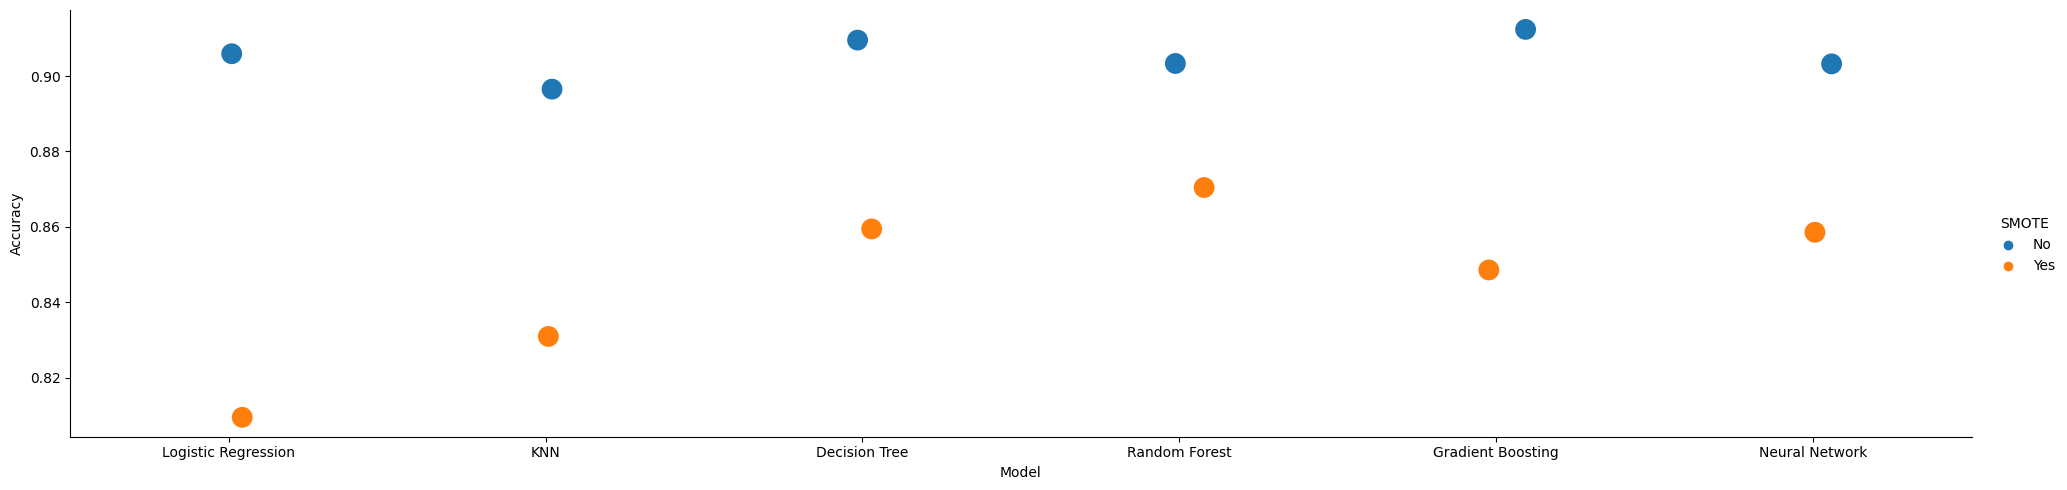

In [57]:
sns.catplot(data = metric_data, x='Model', y='Accuracy', hue='SMOTE', height=5, aspect=4, size=15)

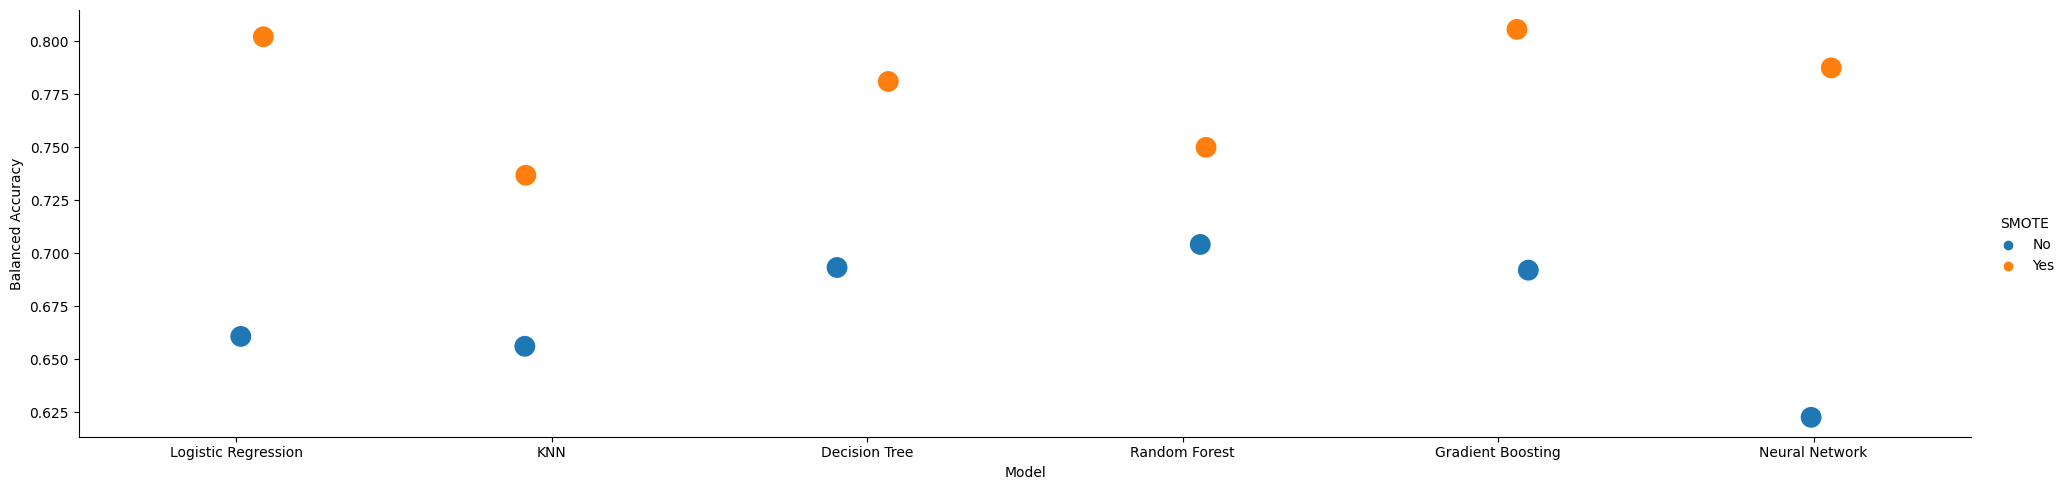

In [58]:
sns.catplot(data = metric_data, x='Model', y='Balanced Accuracy', hue='SMOTE', height=5, aspect=4, size=15)

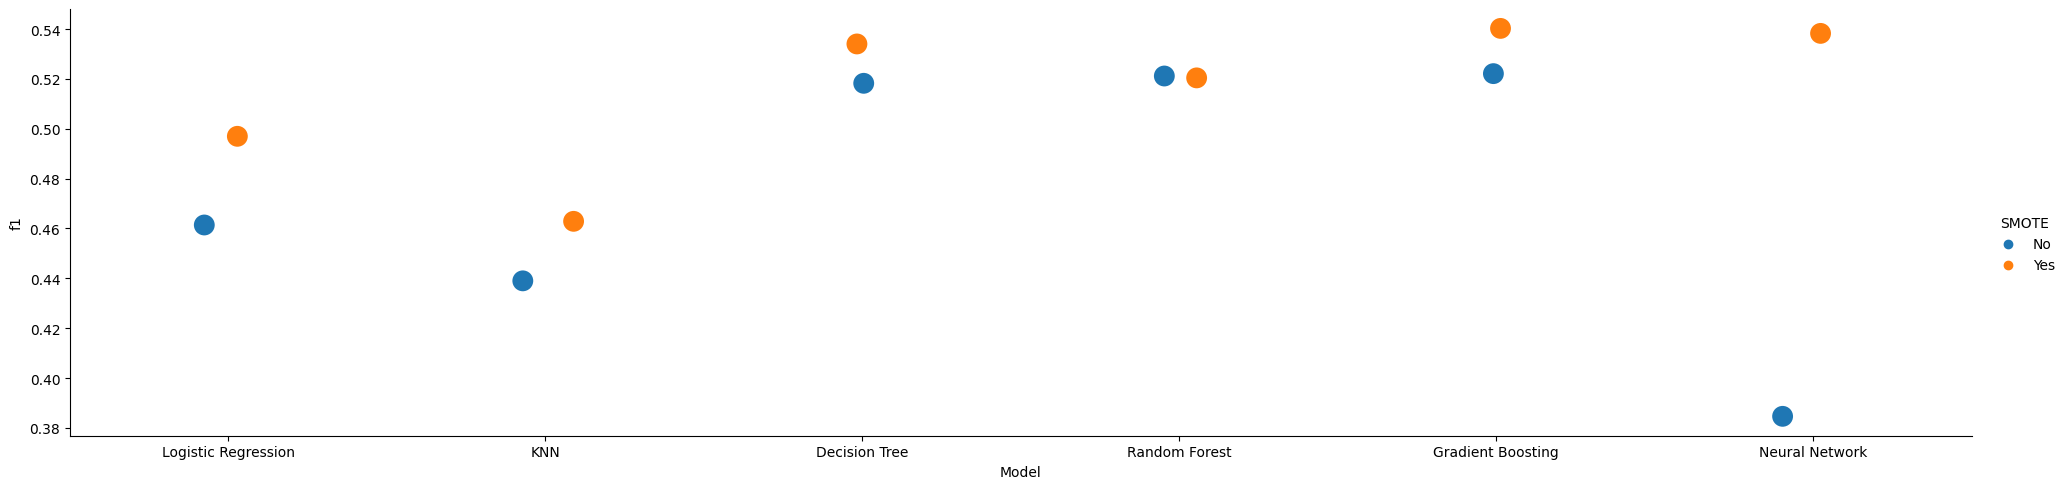

In [59]:
sns.catplot(data = metric_data, x='Model', y='f1', hue='SMOTE', height=5, aspect=4, size=15)

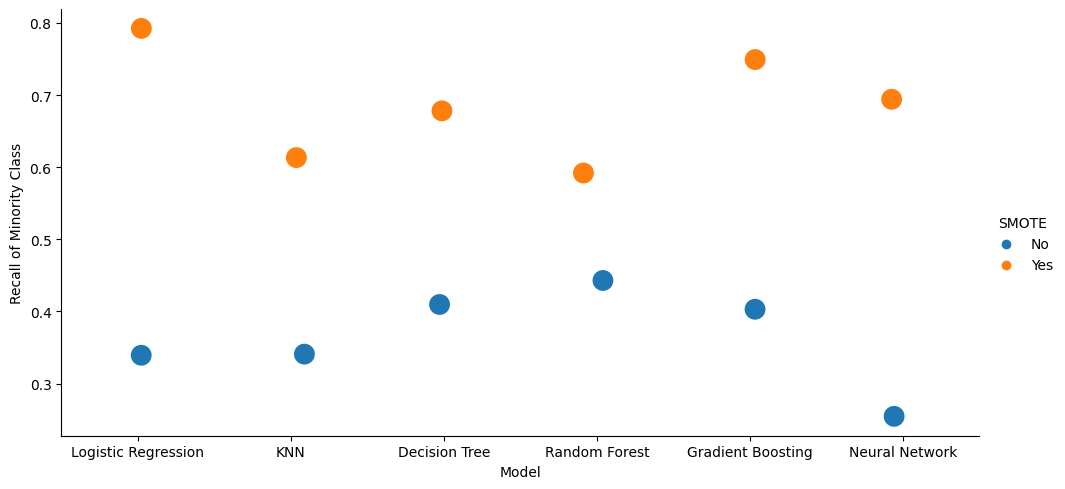

In [60]:
sns.catplot(data = metric_data, x='Model', y='Recall of Minority Class', hue='SMOTE', height=5, aspect=2, size=15)

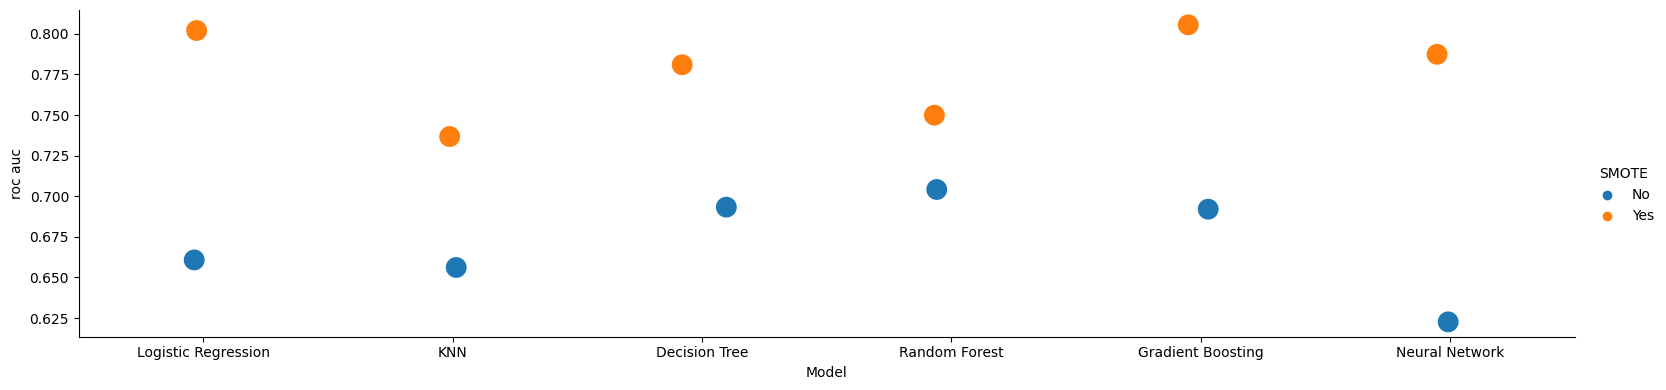

In [61]:
sns.catplot(data = metric_data, x='Model', y='roc auc', hue='SMOTE', height=4, aspect=4, size=15)

## Model Explainability

### Logistic Regression

In [62]:
# Coefficients of LR model
LR1_coeff = {col: coeff for col, coeff in zip(list(X_train.columns), LR_model1.coef_[0])}
LR1_coeff_df = pd.DataFrame.from_dict(LR1_coeff, orient='index', columns=['Coefficient'])
LR1_coeff_df = LR1_coeff_df.sort_values(by='Coefficient', key=abs, ascending=False)
LR1_coeff_df = LR1_coeff_df.reset_index(col_level=0, names='Feature')

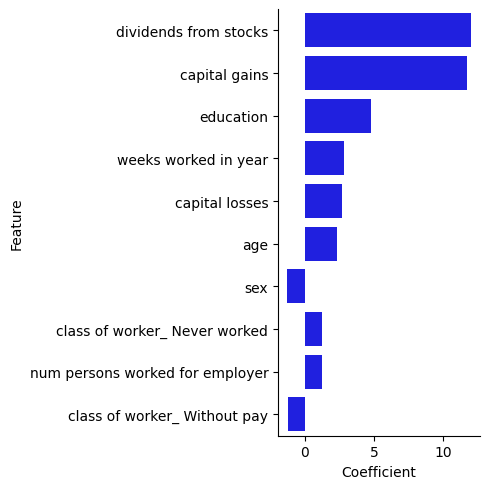

In [63]:
sns.catplot(data=LR1_coeff_df[:10], y='Feature', x='Coefficient', kind='bar', orient='h', color='b')

In [64]:
# Coefficients of LR model with minority resampling
LR2_coeff = {col: coeff for col, coeff in zip(list(X_train.columns), LR_model2.coef_[0])}
LR2_coeff_df = pd.DataFrame.from_dict(LR2_coeff, orient='index', columns=['Coefficient'])
LR2_coeff_df = LR2_coeff_df.sort_values(by='Coefficient', key=abs, ascending=False)
LR2_coeff_df = LR2_coeff_df.reset_index(col_level=0, names='Feature')

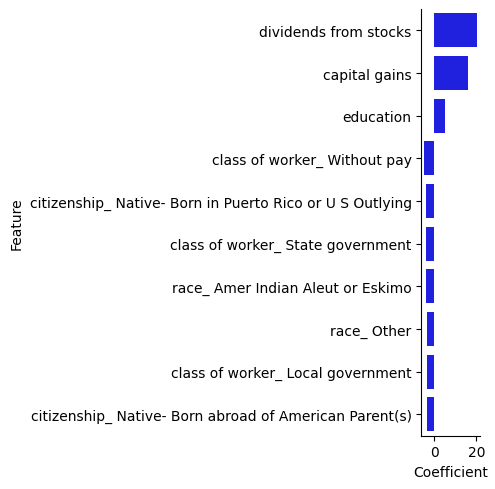

In [65]:
sns.catplot(data=LR2_coeff_df[:10], y='Feature', x='Coefficient', kind='bar', orient='h', color='b')

## Gradient Boosting SHAP values

In [66]:
import shap
explainer1 = shap.Explainer(GB_model1)
shap_values1 = explainer1(X_test)
shap_importance1 = shap_values1.abs.mean(0).values
importance_df = pd.DataFrame({'features': X_train.columns,
                              'importance': shap_importance1})
importance_df.sort_values(by='importance', ascending=False, inplace=True)
importance_df

,features,importance
1,education,5.509382e-01
3,sex,5.010973e-01
0,age,3.920951e-01
8,weeks worked in year,3.038765e-01
6,dividends from stocks,2.266259e-01
7,num persons worked for employer,1.917026e-01
4,capital gains,1.446476e-01
2,marital stat,1.119762e-01
5,capital losses,5.848376e-02
13,class of worker_ Self-employed-incorporated,5.001876e-02


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


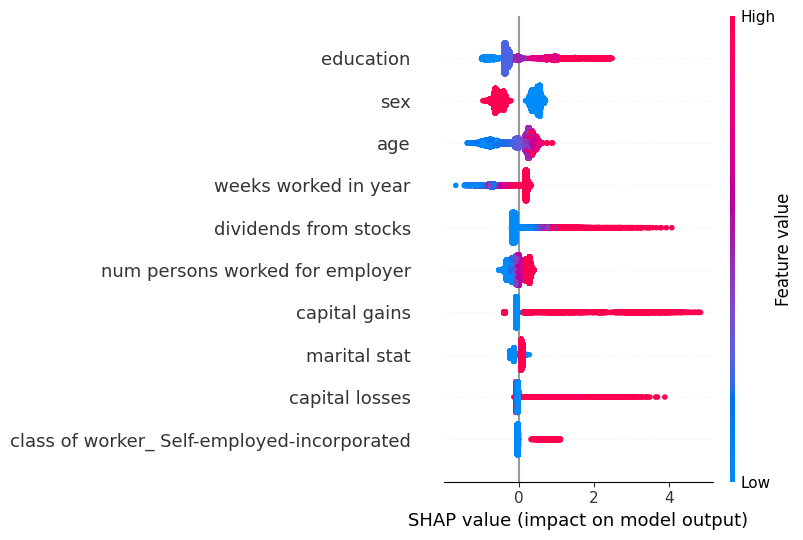

In [67]:
shap.summary_plot(shap_values1, X_test, feature_names=list(X_test.columns), max_display=10)

In [68]:
explainer2 = shap.Explainer(GB_model2)
shap_values2 = explainer2(X_test)
shap_importance2 = shap_values2.abs.mean(0).values
importance_df2 = pd.DataFrame({'features': X_train_adj.columns,
                              'importance': shap_importance2})
importance_df2.sort_values(by='importance', ascending=False, inplace=True)
importance_df2

,features,importance
1,education,0.709661
6,dividends from stocks,0.626259
3,sex,0.568838
0,age,0.487365
8,weeks worked in year,0.348368
7,num persons worked for employer,0.202479
4,capital gains,0.202410
2,marital stat,0.121945
5,capital losses,0.062940
13,class of worker_ Self-employed-incorporated,0.045522


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


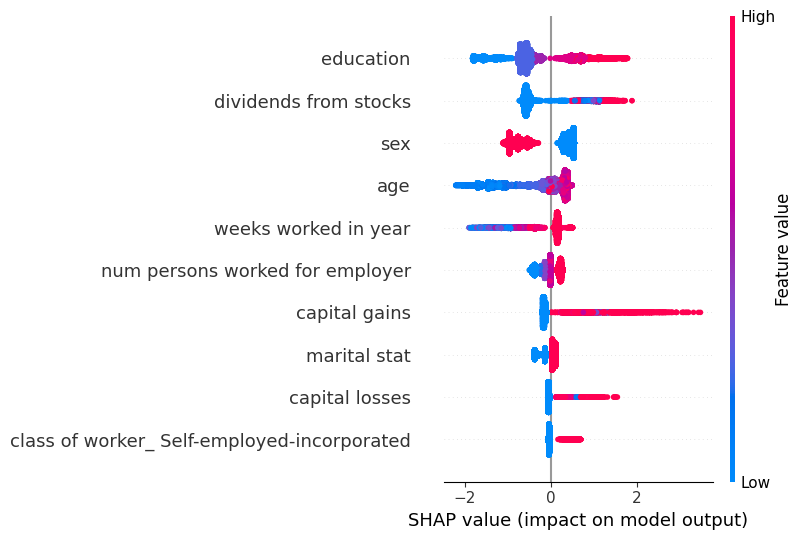

In [69]:
shap.summary_plot(shap_values2, X_test,feature_names=list(X_test.columns), max_display=10)